<h1>Airbnb listing data for NYC 2019</h1>

<p>Airbnb is one of the largest short-term rental services in the world.  As such, they have millions of listings, many of which are in metropolitan areas like LA and NYC.  They currently do not have a public API to get listing data, but fortunately a recent <a href=https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>dataset</a> is available on Kaggle specifically for NYC, and the raw source for this data can be found <a href="http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz">here</a>.  Data for other cities can also be found <a href="http://insideairbnb.com/get-the-data.html">here</a>.</p>

<p>Let's take a look at the <b>listings.csv</b> first, then we'll get to the time series data in <b>calendar.csv</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
listings_df = pd.read_csv('listings.csv.gz')

c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<br/>
<p>There are certain columns that have mixed data. Lets take a look at the general structure of the listings as well as those columns.</p>

In [2]:
print(listings_df.info())
print(listings_df.columns)
for col_index in [60, 61, 93, 94]:
    print(listings_df.columns[col_index])
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50796 entries, 0 to 50795
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(21), object(64)
memory usage: 41.1+ MB
None
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)
price
weekly_price
requires_license
license


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200313233810,2020-03-14,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,...,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200313233810,2020-03-14,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.38
2,3831,https://www.airbnb.com/rooms/3831,20200313233810,2020-03-14,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.71
3,5099,https://www.airbnb.com/rooms/5099,20200313233810,2020-03-14,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.59
4,5114,https://www.airbnb.com/rooms/5114,20200313233810,2020-03-14,Super Room in Great area.,NaN,"First, the area is PERFECT if you want to visi...","First, the area is PERFECT if you want to visi...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,1,2,0,0.56


In [3]:
pd.isna(listings_df.review_scores_rating).sum()

11431

<br/>
<p>As we will see later, those mixed columns are not necessary.  There are also more entries than in the first dataset that we looked at (hopefully for more accurate modeling).  Let's drop the mixed columns and other columns that have irrelevant data, majority incomplete data, or data that can be found in other tables.</p>

In [4]:
# calendar values scraped in a small window between 2019-12-04 and 2019-12-07

listings_clean = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'space', \
    'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', \
    'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', \
    'host_name', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', \
    'host_acceptance_rate', 'host_since', 'host_listings_count', 'host_total_listings_count', \
    'host_verifications', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', \
    'host_identity_verified', 'host_neighbourhood', 'street', 'neighbourhood', 'city', 'state', 'zipcode', \
    'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'instant_bookable', \
    'is_business_travel_ready', 'license', 'jurisdiction_names', 'review_scores_value', 'requires_license', \
    'review_scores_communication', 'bed_type', 'weekly_price', 'monthly_price', \
    'security_deposit', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', \
    'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'has_availability', \
    'calendar_last_scraped', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_accuracy', \
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_location', 'cancellation_policy', \
    'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', \
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', \
    'calculated_host_listings_count_shared_rooms', 'cleaning_fee', 'extra_people', \
    'square_feet', 'property_type', 'minimum_nights_avg_ntm', \
    'maximum_nights_avg_ntm', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365'], axis=1)
print(listings_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50796 entries, 0 to 50795
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            50796 non-null  int64  
 1   summary                       48341 non-null  object 
 2   neighbourhood_cleansed        50796 non-null  object 
 3   neighbourhood_group_cleansed  50796 non-null  object 
 4   latitude                      50796 non-null  float64
 5   longitude                     50796 non-null  float64
 6   room_type                     50796 non-null  object 
 7   accommodates                  50796 non-null  int64  
 8   bathrooms                     50742 non-null  float64
 9   bedrooms                      50719 non-null  float64
 10  beds                          50314 non-null  float64
 11  amenities                     50796 non-null  object 
 12  number_of_reviews             50796 non-null  int64  
 13  r

<br/>
<p>Columns <b>bathrooms, bedrooms, beds</b> have missing data, but thankfully not a lot.  We will try to clean that up.  Let's also rename a couple columns</p>

In [5]:
listings_clean.rename(columns={
    'neighbourhood_cleansed':'neighbourhood',
    'neighbourhood_group_cleansed': 'neighbourhood_group'
}, inplace=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50796 entries, 0 to 50795
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    50796 non-null  int64  
 1   summary               48341 non-null  object 
 2   neighbourhood         50796 non-null  object 
 3   neighbourhood_group   50796 non-null  object 
 4   latitude              50796 non-null  float64
 5   longitude             50796 non-null  float64
 6   room_type             50796 non-null  object 
 7   accommodates          50796 non-null  int64  
 8   bathrooms             50742 non-null  float64
 9   bedrooms              50719 non-null  float64
 10  beds                  50314 non-null  float64
 11  amenities             50796 non-null  object 
 12  number_of_reviews     50796 non-null  int64  
 13  review_scores_rating  39365 non-null  float64
 14  reviews_per_month     40343 non-null  float64
dtypes: float64(7), int6

<br/>
<p>Since the large majority of listings are homes/apts or private rooms, let's keep those listings.</p>

In [6]:
print(listings_clean.room_type.value_counts())
listings_clean = listings_clean.loc[
    (listings_clean.room_type == 'Entire home/apt') |
    (listings_clean.room_type == 'Private room')
]

Entire home/apt    26274
Private room       22895
Shared room         1225
Hotel room           402
Name: room_type, dtype: int64


<br/>
<p>We see some possible outliers for <b>accommodates, bathrooms, bedrooms, beds</b>.</p>

In [7]:
listings_clean.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,reviews_per_month
count,4.916900e+04,49169.000000,49169.000000,49169.000000,49118.000000,49092.000000,48716.000000,49169.000000,38240.000000,39195.000000
mean,2.241675e+07,40.728961,-73.950807,2.890236,1.145079,1.187750,1.543887,25.326242,94.021705,1.276515
std,1.317265e+07,0.054806,0.047685,1.899283,0.421535,0.769927,1.128664,49.059322,8.644751,1.578123
min,2.060000e+03,40.499790,-74.240840,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.010000
25%,1.054268e+07,40.689550,-73.983110,2.000000,1.000000,1.000000,1.000000,1.000000,92.000000,0.180000
50%,2.203498e+07,40.723090,-73.955080,2.000000,1.000000,1.000000,1.000000,5.000000,96.000000,0.630000
75%,3.468498e+07,40.762870,-73.933720,4.000000,1.000000,1.000000,2.000000,25.000000,100.000000,1.900000
max,4.289272e+07,40.911690,-73.711560,22.000000,15.500000,21.000000,40.000000,695.000000,100.000000,33.710000


<br/>
<p>Check for duplicate latitude and longitude value pairs, which most likely means duplicate listings</p>

In [8]:
# https://stackoverflow.com/questions/44481768/remove-duplicate-rows-from-pandas-dataframe-where-only-some-columns-have-the-sam
# https://stackoverflow.com/questions/16167829/in-pandas-how-can-i-reset-index-without-adding-a-new-column

listings_clean = listings_clean.drop_duplicates(subset=['latitude', 'longitude']).reset_index(drop=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48543 entries, 0 to 48542
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    48543 non-null  int64  
 1   summary               46225 non-null  object 
 2   neighbourhood         48543 non-null  object 
 3   neighbourhood_group   48543 non-null  object 
 4   latitude              48543 non-null  float64
 5   longitude             48543 non-null  float64
 6   room_type             48543 non-null  object 
 7   accommodates          48543 non-null  int64  
 8   bathrooms             48492 non-null  float64
 9   bedrooms              48466 non-null  float64
 10  beds                  48091 non-null  float64
 11  amenities             48543 non-null  object 
 12  number_of_reviews     48543 non-null  int64  
 13  review_scores_rating  37836 non-null  float64
 14  reviews_per_month     38788 non-null  float64
dtypes: float64(7), int6

<br/>
<p>Look at non-numerical columns to see if they can be categorized.</p>

In [9]:
# http://benalexkeen.com/mapping-categorical-data-in-pandas/

print(listings_clean.room_type.value_counts())
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())


Entire home/apt    25871
Private room       22672
Name: room_type, dtype: int64
Manhattan        21153
Brooklyn         19889
Queens            5951
Bronx             1182
Staten Island      368
Name: neighbourhood_group, dtype: int64
Williamsburg          3799
Bedford-Stuyvesant    3730
Harlem                2674
Bushwick              2428
Hell's Kitchen        1922
                      ... 
Willowbrook              1
Huguenot                 1
Glen Oaks                1
Rossville                1
New Dorp                 1
Name: neighbourhood, Length: 222, dtype: int64


In [10]:
home_listings = listings_clean.loc[listings_clean.room_type == 'Entire home/apt']
print(home_listings.bedrooms.value_counts())
print(home_listings.beds.value_counts())
print(home_listings.bathrooms.value_counts())

1.0     12872
2.0      6187
0.0      4023
3.0      2052
4.0       485
5.0       127
6.0        41
7.0        14
8.0        10
10.0        4
9.0         3
21.0        1
14.0        1
13.0        1
Name: bedrooms, dtype: int64
1.0     11350
2.0      7948
3.0      3273
4.0      1410
0.0       780
5.0       527
6.0       250
7.0       101
8.0        50
9.0        27
10.0       16
11.0       14
12.0       14
13.0        7
14.0        5
16.0        5
15.0        1
24.0        1
17.0        1
22.0        1
26.0        1
40.0        1
18.0        1
Name: beds, dtype: int64
1.0     21964
2.0      2273
1.5       870
2.5       333
3.0       203
3.5        73
4.0        45
0.5        27
0.0        24
4.5        17
5.0        11
6.0         7
5.5         4
7.5         4
6.5         1
7.0         1
15.5        1
Name: bathrooms, dtype: int64


<p>We see some outliers that may skew any modeling, so let's remove any listing over 10 <b>bedrooms</b>, 12 <b>beds</b>, and 5 <b>bathrooms</b>.  Realistically the vast majority of property owners are not listing super mansions.</p>

In [11]:
listings_clean = listings_clean.loc[
    (listings_clean.bedrooms <= 10) & (listings_clean.beds <=12) & (listings_clean.bathrooms <= 5)
]

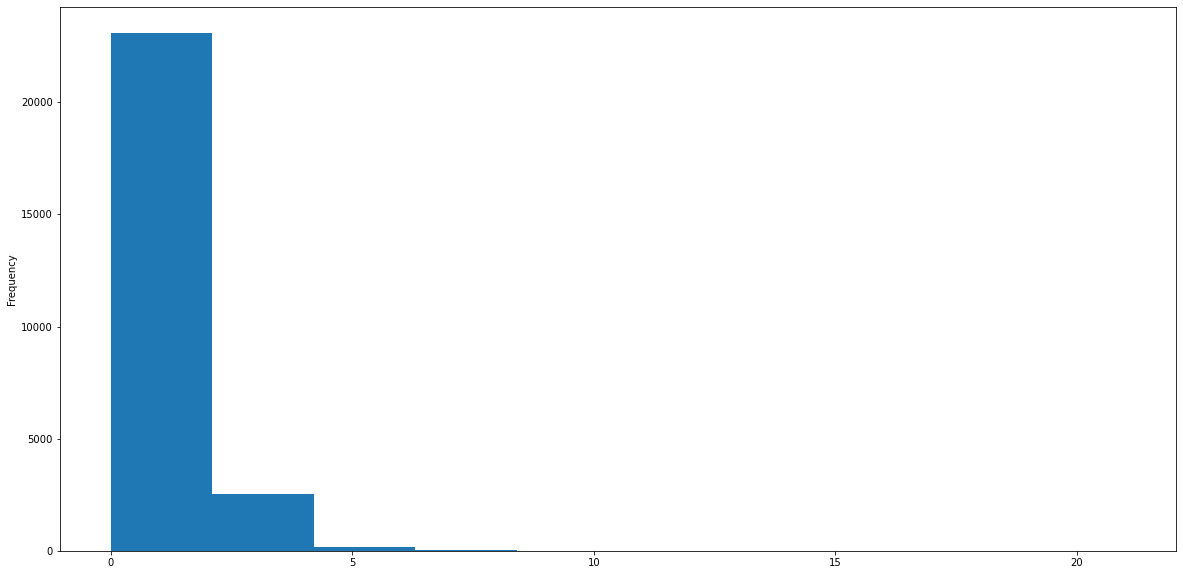

In [12]:
home_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>Home listings are heavily skewed toward single bedroom.  Perhaps we can approximate <b>bedrooms, bathrooms, beds</b> as exponential distributions.</p>
<p>Let's do the same analysis for single room type listings</p>

In [13]:
room_listings = listings_clean.loc[listings_clean.room_type != 'Entire home/apt']
print(room_listings.bedrooms.value_counts())
print(room_listings.beds.value_counts())
print(room_listings.bathrooms.value_counts())

1.0    21050
2.0      566
0.0      467
3.0      123
4.0       45
5.0        8
6.0        2
9.0        1
8.0        1
Name: bedrooms, dtype: int64
1.0     18667
2.0      2298
0.0       768
3.0       351
4.0       127
5.0        27
6.0        17
8.0         3
9.0         2
12.0        2
10.0        1
Name: beds, dtype: int64
1.0    18731
2.0     1586
1.5     1505
3.0      136
2.5      110
0.0       72
0.5       67
4.0       39
3.5       11
4.5        6
Name: bathrooms, dtype: int64


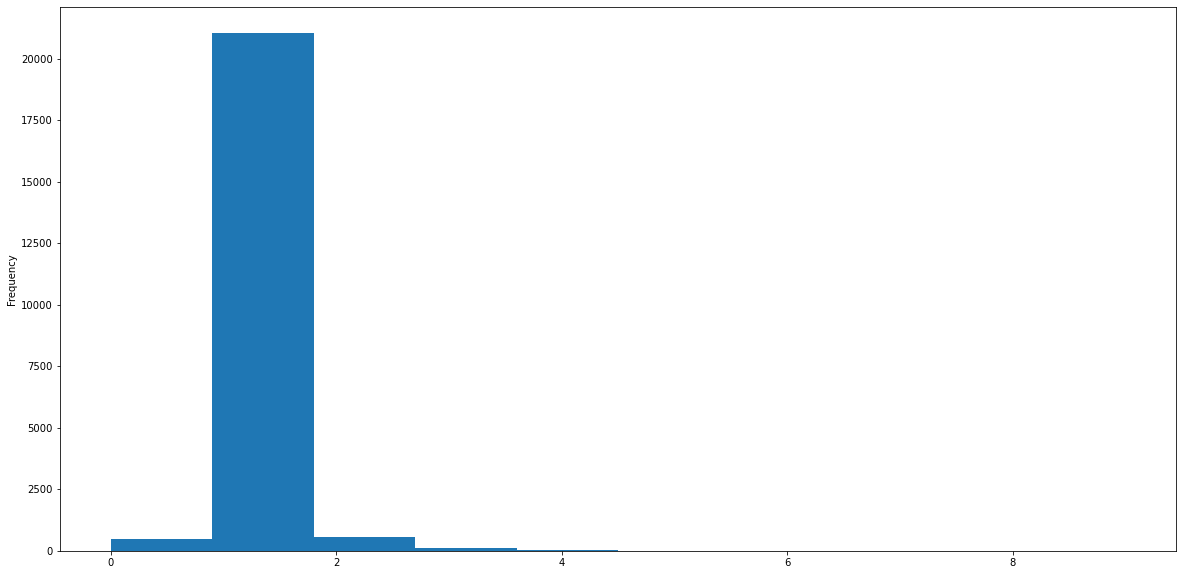

In [14]:
room_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>We get similar results to home listings, which is odd.  Perhaps some single room type listings were incorrectly listed.  That means we may not be able to rely on <b>room_type</b> as a factor in filling in any missing bedroom and bathroom values.</p>

<p>Let's do some data cleaning by filling in the missing <b>bedrooms, bathrooms, beds</b> values (disregarding homes/apts vs. single room since <b>room_type</b> is not always indicative of multiple rooms vs. one room).  0 values can still be considered valid (e.g. studio apt, shared living area, shared bathroom, non-bed type sleeping arrangment).  We will assume that 0.001 degree latitude or longitude <a href=https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162">is about 100 m</a>.  Let's average over an area of 200 m radius from listings that have missing data.  We will group by <b>neighbourhood</b> when calculating the mean.</p>

In [15]:
lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors(row, col_name, col_index):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if math.isnan(item):
        item = listings_clean[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_clean.latitude < lat + lat_diff) \
            & (listings_clean.longitude > long - long_diff) \
            & (listings_clean.longitude < long + long_diff)].groupby(by=listings_clean.neighbourhood).mean().round()[0]
        row[col_index] = item
    return row

listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bathrooms', col_index=7, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bedrooms', col_index=8, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='beds', col_index=9, axis=1)

In [16]:
print(listings_clean.bedrooms.value_counts())
print(listings_clean.bathrooms.value_counts())
print(listings_clean.beds.value_counts())

1.0     33871
2.0      6738
0.0      4479
3.0      2168
4.0       527
5.0       124
6.0        36
7.0        11
8.0         6
9.0         3
10.0        1
Name: bedrooms, dtype: int64
1.0    40583
2.0     3856
1.5     2370
2.5      438
3.0      333
0.0       96
0.5       94
3.5       82
4.0       80
4.5       23
5.0        9
Name: bathrooms, dtype: int64
1.0     29979
2.0     10239
3.0      3624
0.0      1547
4.0      1537
5.0       550
6.0       267
7.0       101
8.0        52
9.0        28
10.0       15
12.0       13
11.0       12
Name: beds, dtype: int64


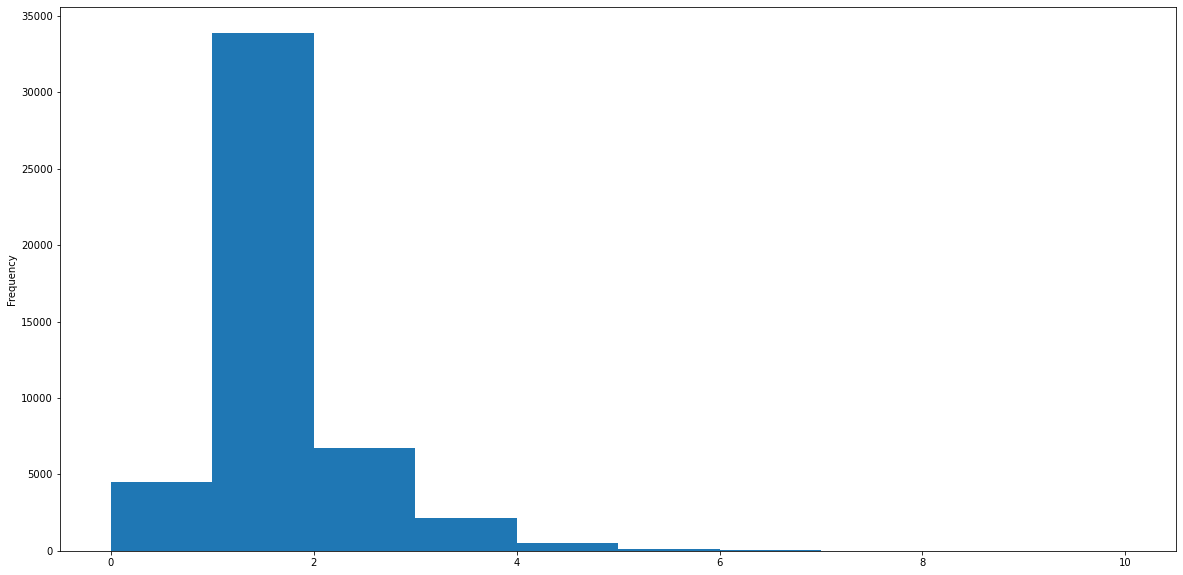

In [17]:
listings_clean.bedrooms.plot(kind='hist', figsize=(20, 10))

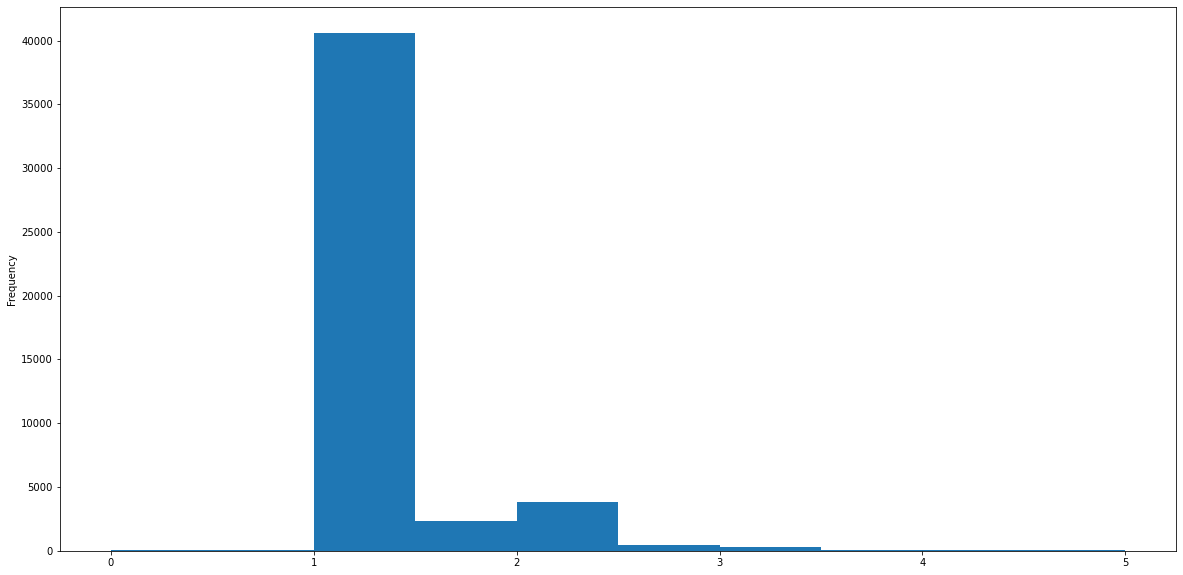

In [18]:
listings_clean.bathrooms.plot(kind='hist', figsize=(20, 10))

<p>After <b>bedrooms, bathrooms, beds</b> cleanup, we are able to see a bit more detail in the distributions.  They are approximately exponential (again skewed toward 1).</p>

<p>Final check on the listings for any missing data.</p>

In [19]:
listings_clean.info()
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47964 entries, 1 to 48542
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    47964 non-null  int64  
 1   summary               45803 non-null  object 
 2   neighbourhood         47964 non-null  object 
 3   neighbourhood_group   47964 non-null  object 
 4   latitude              47964 non-null  float64
 5   longitude             47964 non-null  float64
 6   room_type             47964 non-null  object 
 7   accommodates          47964 non-null  int64  
 8   bathrooms             47964 non-null  float64
 9   bedrooms              47964 non-null  float64
 10  beds                  47964 non-null  float64
 11  amenities             47964 non-null  object 
 12  number_of_reviews     47964 non-null  int64  
 13  review_scores_rating  37615 non-null  float64
 14  reviews_per_month     38551 non-null  float64
dtypes: float64(7), int6

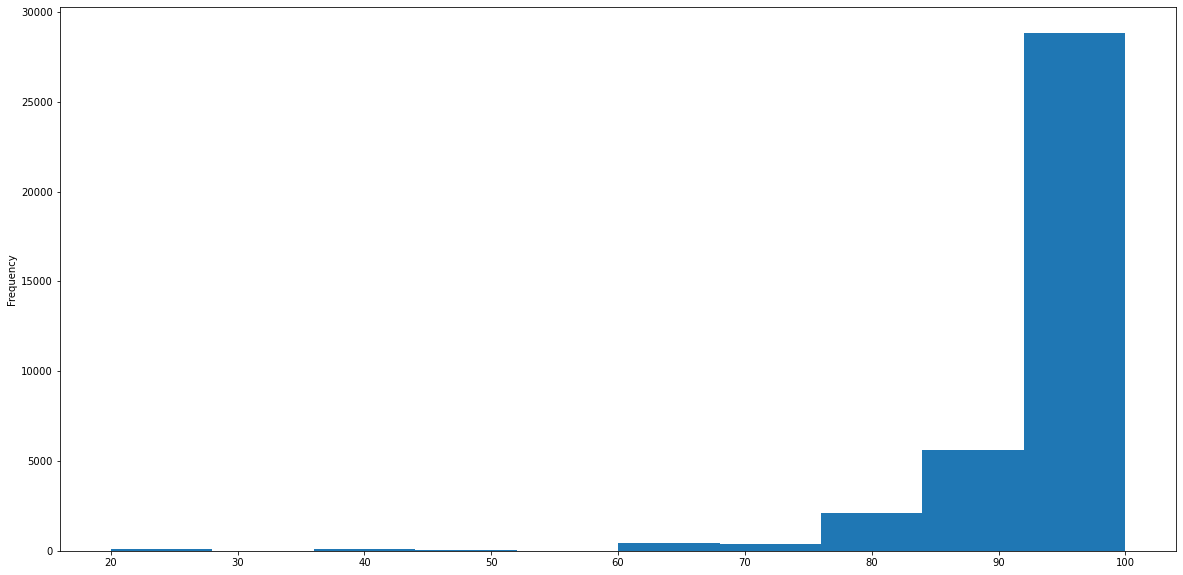

In [20]:
listings_clean.review_scores_rating.plot(kind='hist', figsize=(20, 10))

In [21]:
listings_clean['review_scores_rating'].fillna(listings_clean.review_scores_rating.mean(), inplace=True)

<p>One hot encode the <b>neighbourhood</b> values.  Drop non-numerical columns as well as listing IDs (which do not have any meaning for modeling).  Also convert <b>room_type</b> to 1 and 0 valued <b>entire_home_apt</b>.</p>

In [22]:
def cleanup_neighbourhood(val):
    return val.replace(' ', '_').lower()

listings_clean['neighbourhood'] = listings_clean.neighbourhood.apply(cleanup_neighbourhood)
listings_clean['neighbourhood'] = listings_clean.neighbourhood.astype('category')
listings_clean['neighbourhood'] = listings_clean.neighbourhood.cat.codes

In [23]:
listings_clean['entire_home_apt'] = np.where(listings_clean.room_type == 'Entire home/apt', 1, 0)

In [24]:
import string

def cleanup_amenities(text):
    remove = string.punctuation
    remove = remove.replace("-", "").replace(",", "").replace("/", "")
    text = text.lower().translate({ord(char): None for char in remove})
    text = text.replace("translation missing enhostingamenity49", "")
    text = text.replace("translation missing enhostingamenity50", "")
    text = text.replace(",,", ",").replace("’", "").replace(' / ', ' ').replace('/', ' ')
    text = text.replace(' ', '_').replace('-', '_')
    return text.split(",")

listings_clean['amenities'] = listings_clean['amenities'].apply(cleanup_amenities)

In [25]:
amenities_sparse = listings_clean.amenities.str.join('|').str.get_dummies()
listings_clean = listings_clean.join(amenities_sparse)

In [26]:
print()
for c in amenities_sparse.columns:
    print(c)


24_hour_check_in
_toilet
accessible_height_bed
accessible_height_toilet
air_conditioning
air_purifier
baby_bath
baby_monitor
babysitter_recommendations
baking_sheet
barbecue_utensils
bathtub
bathtub_with_bath_chair
bbq_grill
beach_essentials
beachfront
bed_linens
bread_maker
breakfast
building_staff
buzzer_wireless_intercom
cable_tv
carbon_monoxide_detector
cats
changing_table
childrens_books_and_toys
childrens_dinnerware
cleaning_before_checkout
coffee_maker
cooking_basics
crib
disabled_parking_spot
dishes_and_silverware
dishwasher
dogs
doorman
dryer
electric_profiling_bed
elevator
essentials
ethernet_connection
ev_charger
extra_pillows_and_blankets
extra_space_around_bed
family_kid_friendly
fire_extinguisher
fireplace_guards
firm_mattress
first_aid_kit
fixed_grab_bars_for_shower
fixed_grab_bars_for_toilet
flat_path_to_guest_entrance
free_parking_on_premises
free_street_parking
full_kitchen
game_console
garden_or_backyard
ground_floor_access
gym
hair_dryer
handheld_shower_head
hanger

In [27]:
# import re
# import string
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# remove = string.punctuation

# def tokenize_summary(text):
    
#     text = str(text)
#     text = text.lower().translate({ord(char): None for char in remove})
#     text = re.sub(r'\d+', '', text)
#     text = lemmatizer.lemmatize(text)
#     words = word_tokenize(text)
#     return [w for w in words if w not in stop_words and re.sub('[\W_]+', '', w)]

# listings_clean['summary_tokenized'] = listings_clean['summary'].apply(tokenize_summary)

In [28]:
# import re
# from nltk.tokenize import word_tokenize, punkt
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# stop_words = stopwords.words('english')
# stop_words = stop_words + ['ps', 'hello', 'go', 'everyone', 's', 'sf', 'nt', 'pmam', 'wown', 'see']
# lemmatizer = WordNetLemmatizer()

# def tokenize_summary(text):
#     text = re.sub(r'\d+', '', str(text))
#     tokens = word_tokenize(text)
#     tokens = list(filter(lambda token: punkt.PunktToken(token).is_non_punct, tokens))
#     tokens = [token.translate({ord(char): None for char in remove}) for token in tokens]
#     tokens = [token.lower() for token in tokens]
#     tokens = list(filter(lambda token: token not in stop_words, tokens))
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     return tokens

# text = listings_clean.summary[11]

# tokenize_summary(text)

In [29]:
# summary_tokenized = listings_clean.iloc[:1000,:].summary_tokenized.str.join('|').str.get_dummies()
# print("Number of features from tokenized listing summaries:", len(summary_tokenized.columns))
# for c in summary_tokenized.columns:
#     print(c)

# listings_clean = listings_clean.join(summary_tokenized)

<br/>
<p>Now let's take a look at the time series data for availability, price, and nights.  <a href=http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/calendar.csv.gz><b>Calendar.csv</b></a> comes from the same <a href="http://insideairbnb.com/get-the-data.html">source</a> as <b>listings.csv</b></p>.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
calendar_df = pd.read_csv('calendar.csv.gz', parse_dates=['date'])

<br/>
<p>This time we don't have to deal with columns of mixed data, nor do we have a large number of columns like in the <b>listings_clean</b> table.  We do, however, have over 18 million entries, which makes sense given that this is time series data over a year for 50,000+ listings.  We will have to clean up availability and price.</p>

In [31]:
print(calendar_df.info())
print(calendar_df.columns)
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18540540 entries, 0 to 18540539
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 990.2+ MB
None
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11943,2020-03-14,t,$150.00,$150.00,1,730
1,2060,2020-03-14,t,$100.00,$100.00,1,730
2,2060,2020-03-15,t,$100.00,$100.00,1,730
3,2060,2020-03-16,t,$100.00,$100.00,1,730
4,2060,2020-03-17,t,$100.00,$100.00,1,730


<br/>
<p>On checking for equal distribution of all listings over the relevant time period (assumed for this step to be a year), we see a problem with <b>listing_id</b> 15268792.  Let's just remove it, since it is not worth the effort to build a year's worth of data for that one listing.</p>

In [32]:
print(calendar_df.listing_id.value_counts())
calendar_clean = calendar_df[calendar_df.listing_id != 15268792]


327521      365
34444336    365
14487072    365
840731      365
39526115    365
           ... 
18040970    365
18221090    365
40199757    365
29302018    365
30226855    365
Name: listing_id, Length: 50796, dtype: int64


<br/>
<p>Since this data set was captured in 2019, we must clean up dates that have year 2020.  Then drop any duplicate <b>listing_id, date</b> combos.  Then check that all days add up to a calendar year for each <b>listing_id</b>.</p>

In [33]:
# https://stackoverflow.com/questions/50674011/replace-the-year-in-pandas-datetime-column
# https://stackoverflow.com/questions/28773342/truncate-timestamp-column-to-hour-precision-in-pandas-dataframe

# calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
#                             calendar_clean['date'] - pd.to_timedelta(365, unit='D') + pd.to_timedelta(12, unit='h'))
calendar_clean['date'] = calendar_clean['date'] - pd.to_timedelta(365, unit='D') + pd.to_timedelta(12, unit='h')
calendar_clean['date'] = calendar_clean['date'].dt.floor('D')

c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [34]:
calendar_clean = calendar_clean.drop_duplicates(subset=['listing_id', 'date']).reset_index(drop=True)
print(calendar_clean.listing_id.value_counts())

327521      365
34444336    365
14487072    365
840731      365
39526115    365
           ... 
18040970    365
18221090    365
40199757    365
29302018    365
30226855    365
Name: listing_id, Length: 50795, dtype: int64


<br/>
<p>Verify that all listing_id values can be found in the <b>listings_clean</b> table.  If not, then remove rows with listing_id values don't exist in the other table.</p>

In [35]:
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

ids_match = calendar_clean.listing_id.isin(listings_clean.id)
print(ids_match.value_counts())

True     17506495
False     1033680
Name: listing_id, dtype: int64


In [36]:
calendar_clean = calendar_clean[calendar_clean.listing_id.isin(listings_clean.id)]
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17506495 entries, 0 to 18540174
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1.0+ GB


<br/>
<p>Translate all <b>available</b> values to 1 (available) or 0 (unavailable).</p>

In [37]:
print(calendar_clean.available.value_counts())
calendar_clean['available'] = np.where(calendar_clean.available == 't', 1, 0)
print(calendar_clean.available.value_counts())

f    11950610
t     5555885
Name: available, dtype: int64
0    11950610
1     5555885
Name: available, dtype: int64


<br/>
<p>Less than 1% of the entries have <b>adjusted_price</b> not equal to <b>price</b>, but we will use <b>adjusted_price</b> anyway and clean it up to be numerical</p>

In [38]:
calendar_clean[calendar_clean.price != calendar_clean.adjusted_price]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
15017,6990,2019-03-15,0,$65.00,$59.00,30,700
15018,6990,2019-03-16,0,$65.00,$59.00,30,700
15019,6990,2019-03-17,0,$65.00,$59.00,30,700
19268,15711,2019-03-15,0,$225.00,$203.00,1,1125
19269,15711,2019-03-16,1,$200.00,$180.00,1,1125
...,...,...,...,...,...,...,...
18483618,42817244,2019-04-01,1,$65.00,$52.00,2,1125
18515108,42838968,2019-03-15,0,$51.00,$46.00,1,1125
18515109,42838968,2019-03-16,0,$51.00,$46.00,1,1125
18515110,42838968,2019-03-17,0,$51.00,$46.00,1,1125


In [39]:
calendar_clean['price_cleansed'] = calendar_clean.adjusted_price\
.str.replace('$', '').str.replace(',', '').astype('float')

In [40]:
calendar_clean = calendar_clean.drop(['adjusted_price', 'price'], axis=1)
calendar_clean.rename(columns={'price_cleansed': 'price'}, inplace=True)

<br/>
<p>Now is a good time to check the state of the table.  All columns except for <b>maximum_nights</b> seem to have useful data.  The large majority of listings allowing over 1000 nights for a short-term rental means that, for practical purposes, it is limitless.</p>

In [41]:
calendar_clean.info()
calendar_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17506495 entries, 0 to 18540174
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int32         
 3   minimum_nights  int64         
 4   maximum_nights  int64         
 5   price           float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 868.2 MB


,listing_id,date,available,minimum_nights,maximum_nights,price
0,11943,2019-03-15,1,1,730,150.0
366,2595,2019-03-15,0,7,1125,175.0
367,2595,2019-03-16,0,7,1125,175.0
368,2595,2019-03-17,0,7,1125,175.0
369,2595,2019-03-18,0,7,1125,175.0


In [42]:
calendar_clean.describe()

,listing_id,available,minimum_nights,maximum_nights,price
count,1.750650e+07,1.750650e+07,1.750650e+07,1.750650e+07,1.750523e+07
mean,2.223199e+07,3.173614e-01,9.887199e+00,6.819442e+05,1.563684e+02
std,1.309926e+07,4.654494e-01,4.511643e+01,3.822018e+07,2.695753e+02
min,2.595000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.035809e+07,0.000000e+00,2.000000e+00,3.000000e+01,7.000000e+01
50%,2.190929e+07,0.000000e+00,3.000000e+00,1.125000e+03,1.100000e+02
75%,3.441617e+07,1.000000e+00,5.000000e+00,1.125000e+03,1.790000e+02
max,4.289272e+07,1.000000e+00,1.250000e+03,2.147484e+09,1.000000e+04


In [43]:
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17506495 entries, 0 to 18540174
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int32         
 3   minimum_nights  int64         
 4   maximum_nights  int64         
 5   price           float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 868.2 MB


<br/>
<p>Since travel patterns are usually seasonal, let's average availability, min nights required, and price over each season and the whole year.</p>

In [44]:
available_year_avg = calendar_clean.groupby(by='listing_id').available.mean()
available_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id').available.mean()
available_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id').available.mean()
available_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id').available.mean()
available_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id').available.mean()
available_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id').available.mean()
available_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id').available.mean()
available_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id').available.mean()

calendar_averages = pd.DataFrame(available_year_avg)
calendar_averages.rename(columns={'available': 'available_year_avg'}, inplace=True)
calendar_averages['available_winter_avg'] = available_winter_avg
calendar_averages['available_spring_avg'] = available_spring_avg
calendar_averages['available_summer_avg'] = available_summer_avg
calendar_averages['available_fall_avg'] = available_fall_avg
calendar_averages['available_jan_avg'] = available_jan_avg
calendar_averages['available_jun_avg'] = available_jun_avg
calendar_averages['available_dec_avg'] = available_dec_avg


In [45]:
min_nights_year_avg = calendar_clean.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['minimum_nights'].mean()

calendar_averages['min_nights_year_avg'] = min_nights_year_avg
calendar_averages['min_nights_winter_avg'] = min_nights_winter_avg
calendar_averages['min_nights_spring_avg'] = min_nights_spring_avg
calendar_averages['min_nights_summer_avg'] = min_nights_summer_avg
calendar_averages['min_nights_fall_avg'] = min_nights_fall_avg
calendar_averages['min_nights_jan_avg'] = min_nights_jan_avg
calendar_averages['min_nights_jun_avg'] = min_nights_jun_avg
calendar_averages['min_nights_dec_avg'] = min_nights_dec_avg

In [46]:
price_year_avg = calendar_clean.groupby(by='listing_id')['price'].mean()
price_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['price'].mean()
price_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['price'].mean()
price_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['price'].mean()
price_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['price'].mean()
price_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['price'].mean()
price_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['price'].mean()
price_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['price'].mean()

calendar_averages['price_year_avg'] = price_year_avg
calendar_averages['price_winter_avg'] = price_winter_avg
calendar_averages['price_spring_avg'] = price_spring_avg
calendar_averages['price_summer_avg'] = price_summer_avg
calendar_averages['price_fall_avg'] = price_fall_avg
calendar_averages['price_jan_avg'] = price_jan_avg
calendar_averages['price_jun_avg'] = price_jun_avg
calendar_averages['price_dec_avg'] = price_dec_avg

In [47]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47963 entries, 2595 to 42892717
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   available_year_avg     47963 non-null  float64
 1   available_winter_avg   47963 non-null  float64
 2   available_spring_avg   47963 non-null  float64
 3   available_summer_avg   47963 non-null  float64
 4   available_fall_avg     47963 non-null  float64
 5   available_jan_avg      47963 non-null  float64
 6   available_jun_avg      47963 non-null  float64
 7   available_dec_avg      47963 non-null  float64
 8   min_nights_year_avg    47963 non-null  float64
 9   min_nights_winter_avg  47963 non-null  float64
 10  min_nights_spring_avg  47963 non-null  float64
 11  min_nights_summer_avg  47963 non-null  float64
 12  min_nights_fall_avg    47963 non-null  float64
 13  min_nights_jan_avg     47963 non-null  float64
 14  min_nights_jun_avg     47963 non-null  float64
 

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,47963.000000,47963.000000,47963.000000,47963.000000,47963.000000,47963.000000,47963.000000,47963.000000,47963.000000,47963.000000,...,47963.000000,47963.000000,47963.000000,47960.000000,47963.000000,47959.000000,47963.000000,47960.000000,47959.000000,47960.000000
mean,0.317361,0.271994,0.351256,0.357900,0.287850,0.271966,0.362674,0.268977,9.887199,10.086818,...,9.976670,10.100771,156.363032,156.774582,151.648100,157.469176,159.559367,155.834429,155.748163,159.050139
std,0.365817,0.430120,0.368600,0.429661,0.423971,0.440667,0.427493,0.430418,44.262924,46.158385,...,45.080187,46.305770,250.721635,273.069386,231.135245,256.267187,276.985170,275.479382,243.008040,269.386100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.980822,2.000000,...,2.000000,2.000000,69.880822,70.000000,68.000000,69.978261,70.000000,70.000000,69.000000,70.000000
50%,0.164384,0.000000,0.208791,0.119565,0.000000,0.000000,0.033333,0.000000,2.994521,3.000000,...,3.000000,3.000000,110.000000,110.000000,107.000000,110.000000,110.000000,110.000000,109.133333,110.000000
75%,0.613699,0.813187,0.703297,0.923913,0.813187,0.967742,0.933333,0.806452,5.000000,5.000000,...,5.000000,5.000000,180.000000,179.285714,175.000000,180.000000,180.000000,178.822581,180.000000,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


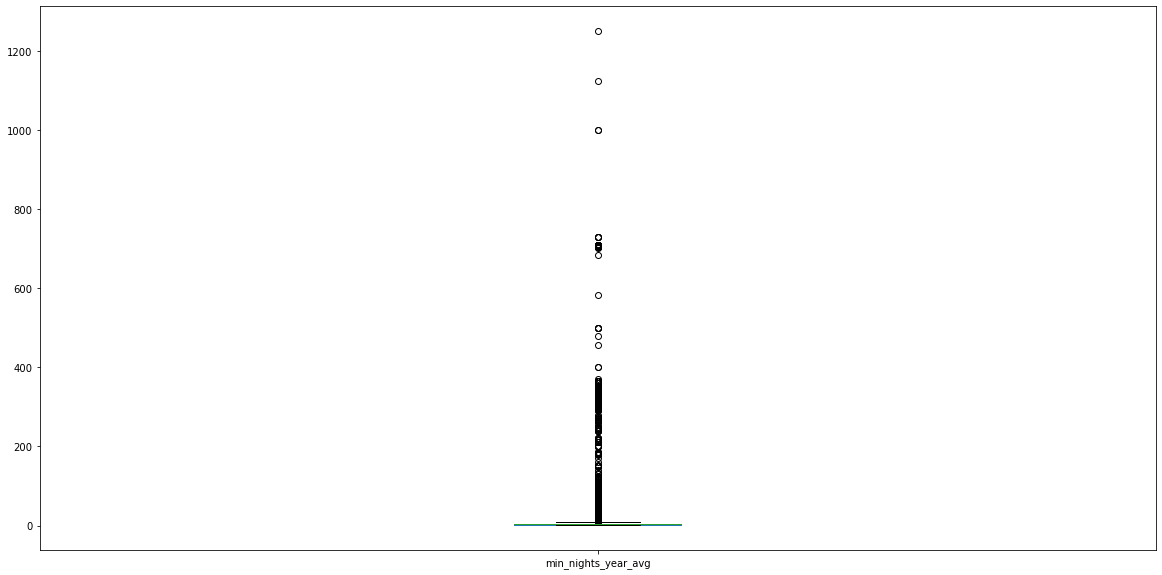

In [48]:
calendar_averages.min_nights_year_avg.plot(kind='box', figsize=(20, 10))

<p>1000+ <b>minimum_nights</b> is extremely high and unrealistic.  Box plot shows outliers above 10 nights, and the 3rd quartile level is 5 nights.</p>

<p>Let's drop any entry that averages over 30 minimum nights.</p>

In [49]:
calendar_averages = calendar_averages.loc[
    (calendar_averages.min_nights_year_avg <= 30) & 
    (calendar_averages.min_nights_winter_avg <= 30) &
    (calendar_averages.min_nights_spring_avg <= 30) &
    (calendar_averages.min_nights_summer_avg <= 30) &
    (calendar_averages.min_nights_fall_avg <= 30) &
    (calendar_averages.min_nights_jan_avg <= 30) &
    (calendar_averages.min_nights_jun_avg <= 30) &
    (calendar_averages.min_nights_dec_avg <= 30)
]

<br/>
<p>The box plot shows clear outliers above \$1000 average nightly price, and the 3rd quartile level is \$180.  Let's drop all listings above \$1000</p>

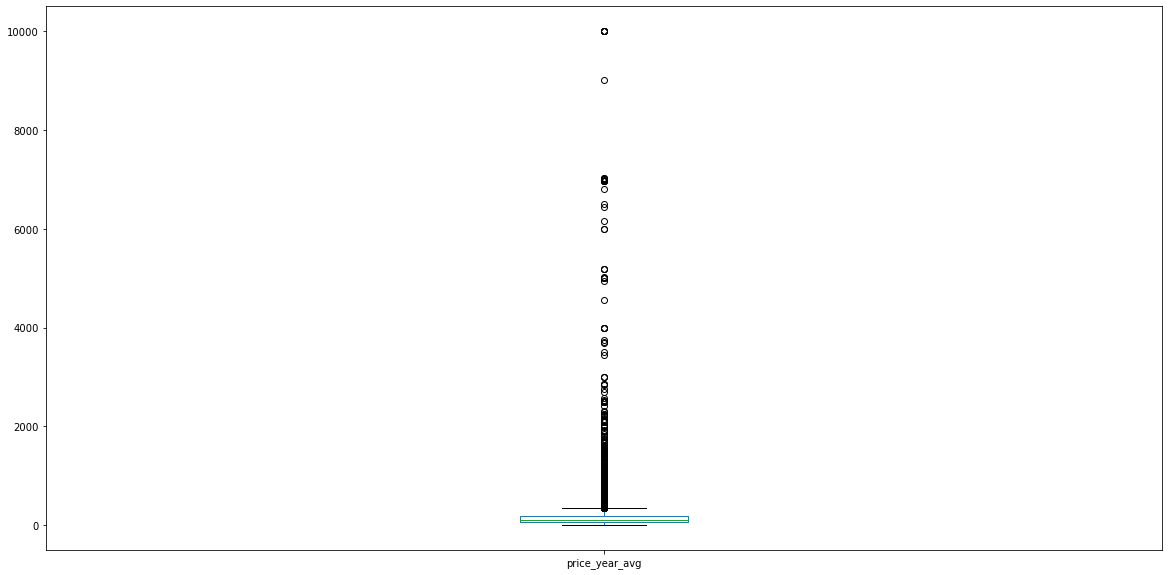

In [50]:
calendar_averages.price_year_avg.plot(kind='box', figsize=(20, 10))

In [51]:
calendar_averages = calendar_averages.loc[
    (calendar_averages.price_year_avg <= 1000) &
    (calendar_averages.price_winter_avg <= 1000) &
    (calendar_averages.price_spring_avg <= 1000) &
    (calendar_averages.price_summer_avg <= 1000) &
    (calendar_averages.price_fall_avg <= 1000) &
    (calendar_averages.price_jan_avg <= 1000) &
    (calendar_averages.price_jun_avg <= 1000) &
    (calendar_averages.price_dec_avg <= 1000)
]

In [52]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46512 entries, 2595 to 42892717
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   available_year_avg     46512 non-null  float64
 1   available_winter_avg   46512 non-null  float64
 2   available_spring_avg   46512 non-null  float64
 3   available_summer_avg   46512 non-null  float64
 4   available_fall_avg     46512 non-null  float64
 5   available_jan_avg      46512 non-null  float64
 6   available_jun_avg      46512 non-null  float64
 7   available_dec_avg      46512 non-null  float64
 8   min_nights_year_avg    46512 non-null  float64
 9   min_nights_winter_avg  46512 non-null  float64
 10  min_nights_spring_avg  46512 non-null  float64
 11  min_nights_summer_avg  46512 non-null  float64
 12  min_nights_fall_avg    46512 non-null  float64
 13  min_nights_jan_avg     46512 non-null  float64
 14  min_nights_jun_avg     46512 non-null  float64
 

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,...,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000
mean,0.310104,0.264459,0.345794,0.350036,0.279688,0.264468,0.355417,0.261052,5.542132,5.549577,...,5.555782,5.553404,142.704208,142.376723,139.351435,143.930061,145.145132,141.425145,143.314967,145.172397
std,0.363201,0.426325,0.366932,0.427010,0.419698,0.436770,0.424458,0.426004,8.093845,8.131298,...,8.135043,8.142107,116.779630,116.320663,114.123780,119.382099,120.920436,115.528820,120.438195,121.907988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.575342,1.428571,...,1.533333,1.411290,69.115068,70.000000,67.373626,69.019022,70.000000,70.000000,68.191667,70.000000
50%,0.150685,0.000000,0.197802,0.108696,0.000000,0.000000,0.033333,0.000000,2.430137,2.329670,...,2.400000,2.387097,108.506849,108.000000,105.000000,108.717391,110.000000,108.000000,106.000000,109.177419
75%,0.580822,0.703297,0.692308,0.902174,0.736264,0.935484,0.900000,0.677419,5.000000,5.000000,...,5.000000,5.000000,175.657534,175.000000,174.304945,178.000000,179.000000,175.000000,175.066667,178.516129
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,30.000000,...,30.000000,30.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


<p>We still have to deal with price outliers, but let's merge the <b>calendar_averages</b> and <b>listings_clean</b> tables on listing ID so we can use geographic data to average over nearest neighbors.</p>

In [53]:
# https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

listings_clean = listings_clean.loc[listings_clean.id != 15268792]
listings_clean = listings_clean.loc[listings_clean.id.isin(calendar_averages.index)]
listings_merge = pd.merge(listings_clean, calendar_averages, left_on='id', right_index=True)

In [54]:
listings_merge.info()
listings_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46512 entries, 1 to 48542
Columns: 171 entries, id to price_dec_avg
dtypes: float64(31), int16(1), int32(1), int64(134), object(4)
memory usage: 60.6+ MB


,id,summary,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
1,2595,"Beautiful, spacious skylit studio in the heart...",128,Manhattan,40.75362,-73.98377,Entire home/apt,2,1.0,0.0,...,7.0,7.0,176.386301,177.714286,175.406593,175.000000,177.439560,177.741935,175.000000,177.741935
2,3831,Urban retreat: enjoy 500 s.f. floor in 1899 br...,40,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,...,1.0,1.0,81.320548,81.000000,81.483516,81.065217,81.736264,80.258065,80.433333,81.064516
3,5099,My large 1 bedroom apartment has a true New Yo...,138,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,...,3.0,3.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
6,5178,Please don’t expect the luxury here just a bas...,96,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,...,2.0,2.0,78.863014,79.000000,78.450549,79.000000,79.000000,79.000000,79.000000,79.000000
7,5203,"Our best guests are seeking a safe, clean, spa...",203,Manhattan,40.80178,-73.96723,Private room,1,1.0,1.0,...,2.0,2.0,77.947945,79.428571,75.637363,77.304348,79.428571,79.483871,75.000000,79.387097


In [55]:
listings_merge.describe()

,id,neighbourhood,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.651200e+04,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,...,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000
mean,2.216350e+07,106.547601,40.728619,-73.950165,2.866486,1.135460,1.177675,1.524940,26.141426,94.076992,...,5.555782,5.553404,142.704208,142.376723,139.351435,143.930061,145.145132,141.425145,143.314967,145.172397
std,1.308181e+07,69.533597,0.055158,0.047766,1.819444,0.383943,0.726102,1.039615,49.781665,7.581204,...,8.135043,8.142107,116.779630,116.320663,114.123780,119.382099,120.920436,115.528820,120.438195,121.907988
min,2.595000e+03,0.000000,40.499790,-74.240840,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.026870e+07,50.000000,40.689000,-73.982400,2.000000,1.000000,1.000000,1.000000,1.000000,93.000000,...,1.533333,1.411290,69.115068,70.000000,67.373626,69.019022,70.000000,70.000000,68.191667,70.000000
50%,2.182269e+07,95.000000,40.722400,-73.954520,2.000000,1.000000,1.000000,1.000000,6.000000,95.000000,...,2.400000,2.387097,108.506849,108.000000,105.000000,108.717391,110.000000,108.000000,106.000000,109.177419
75%,3.435617e+07,177.000000,40.762963,-73.932928,4.000000,1.000000,1.000000,2.000000,27.000000,99.000000,...,5.000000,5.000000,175.657534,175.000000,174.304945,178.000000,179.000000,175.000000,175.066667,178.516129
max,4.289272e+07,221.000000,40.910550,-73.711560,16.000000,5.000000,10.000000,12.000000,695.000000,100.000000,...,30.000000,30.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


<br/>
<p>Availability seems to be a heavy tailed distribution, with most listings unavailable over the year.  This suggests a high average utilization of rentals in NYC, but there are still a lot of rentals available.</p>

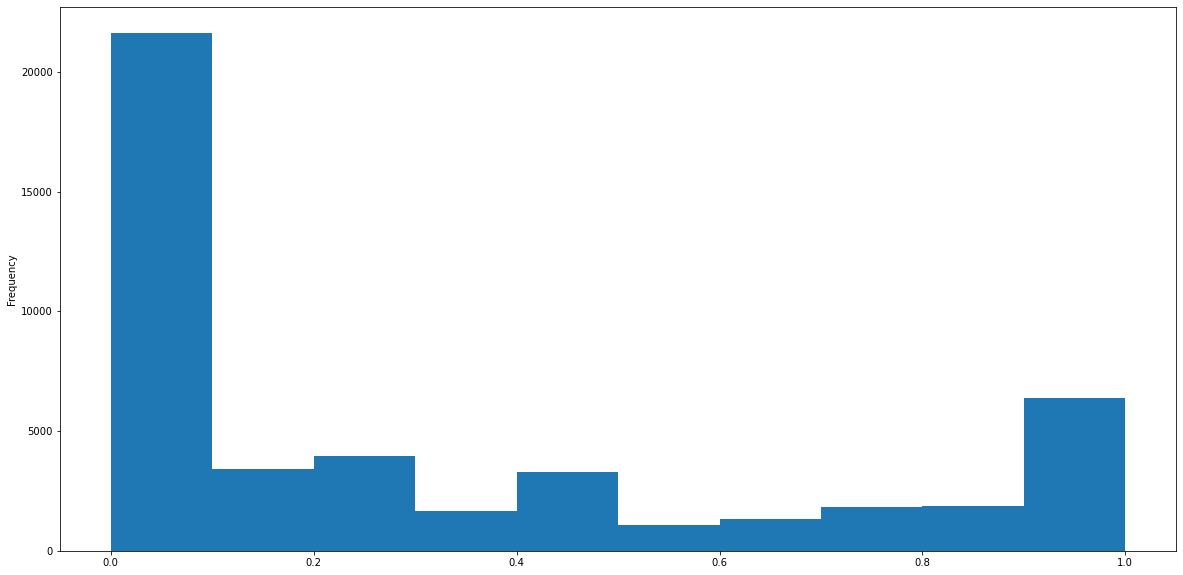

In [56]:
plt = listings_merge.available_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even in a low season like winter, there seems to be low availability.</p>

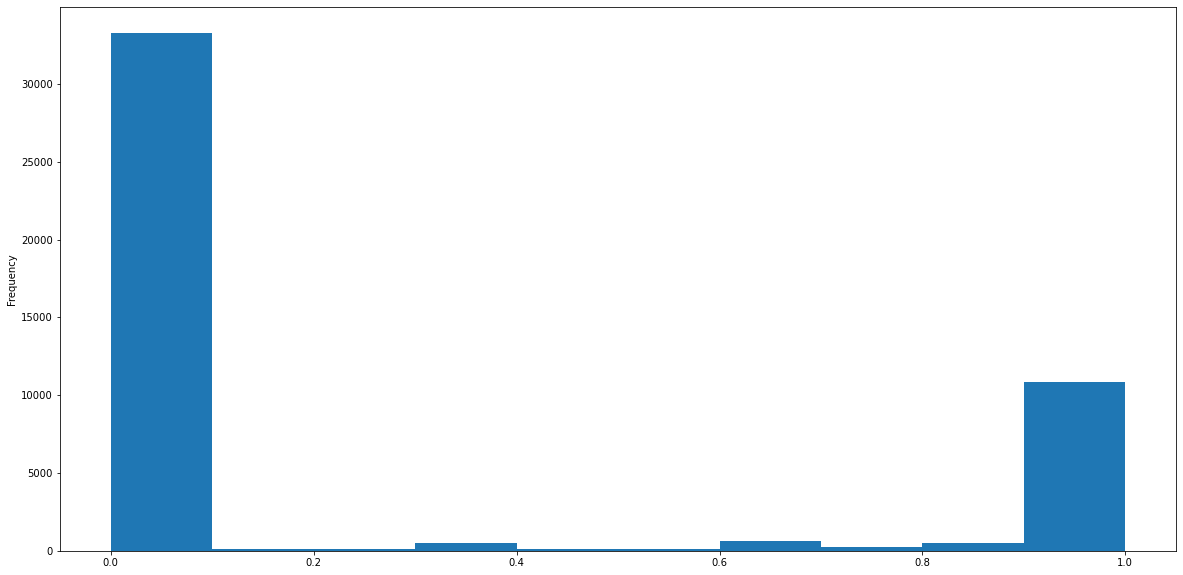

In [57]:
plt = listings_merge.available_winter_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Plotting the log of the minimum nights required we see that it approximates an exponential distribution.</p>

1.000000     11002
2.000000     10779
3.000000      7224
30.000000     3360
4.000000      2930
             ...  
6.641096         1
29.539726        1
1.832877         1
13.558904        1
3.175342         1
Name: min_nights_year_avg, Length: 1356, dtype: int64
30.000000    3360
7.000000     1770
6.000000      656
14.000000     471
10.000000     429
             ... 
9.358904        1
6.402740        1
27.794521       1
29.501370       1
21.832877       1
Name: min_nights_year_avg, Length: 614, dtype: int64


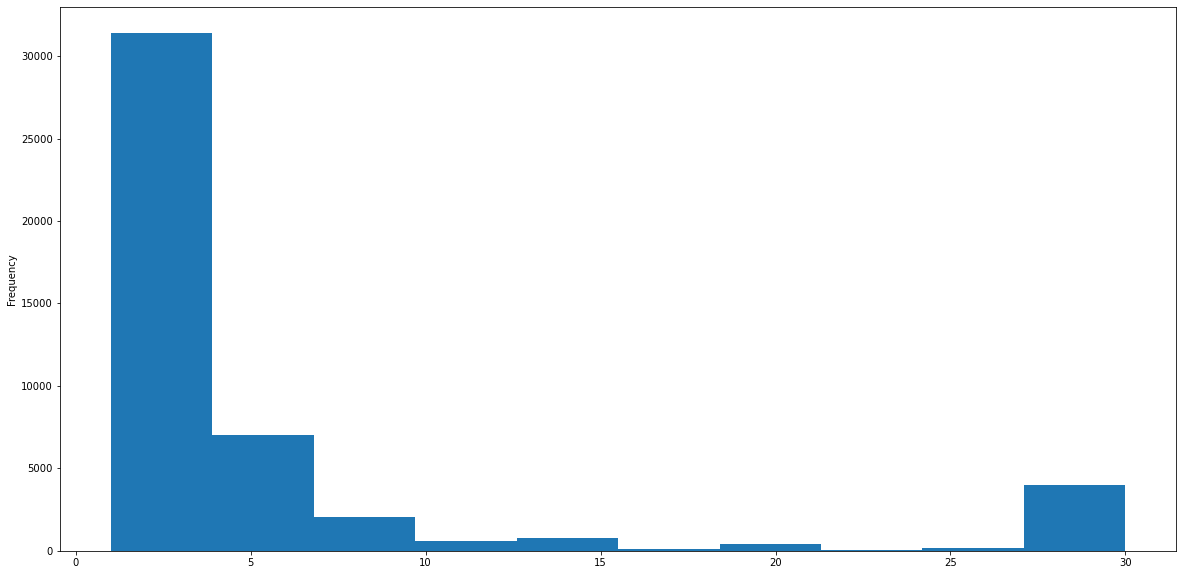

In [58]:
min_nights_75_perc = listings_merge.loc[listings_merge.min_nights_year_avg > 5].min_nights_year_avg.value_counts()
print(listings_merge.min_nights_year_avg.value_counts())
print(min_nights_75_perc)
plt = listings_merge.min_nights_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>There isn't much detail in plot of average prices over the year.  We can't plot the log of average prices due to some zero values that need to be cleaned up.</p>

150.000000    881
100.000000    847
200.000000    655
50.000000     601
75.000000     546
             ... 
323.301370      1
100.246575      1
97.816438       1
118.479452      1
214.408219      1
Name: price_year_avg, Length: 22239, dtype: int64
200.000000    655
250.000000    494
300.000000    269
225.000000    185
350.000000    152
             ... 
236.342466      1
204.953425      1
951.621918      1
425.479452      1
194.287671      1
Name: price_year_avg, Length: 6167, dtype: int64


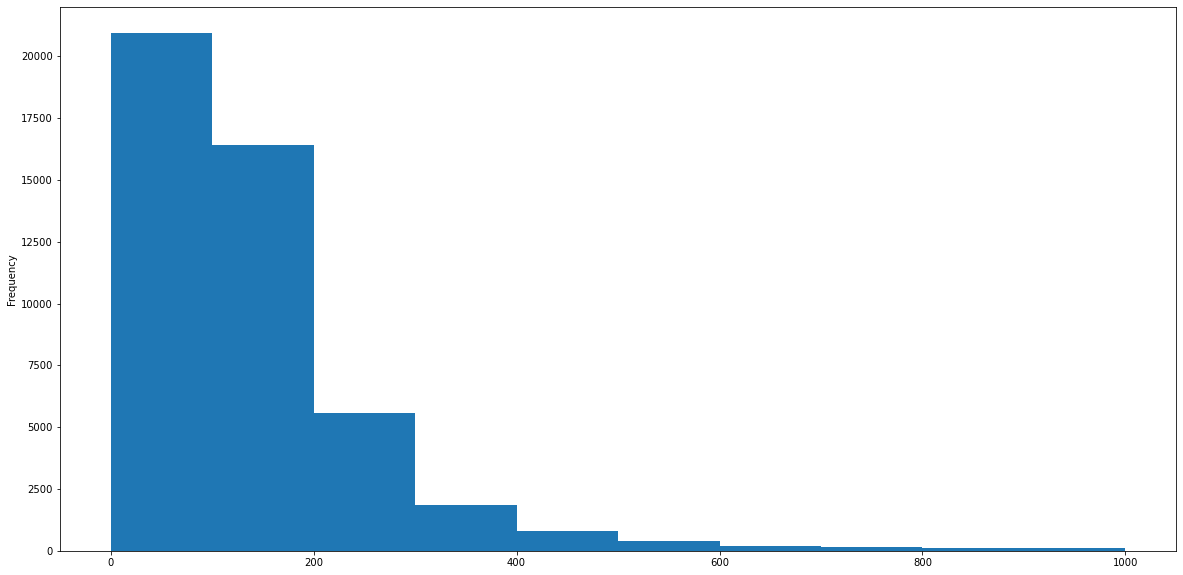

In [59]:
price_75_perc = listings_merge.loc[listings_merge.price_year_avg > 180].price_year_avg.value_counts()
print(listings_merge.price_year_avg.value_counts())
print(price_75_perc)
plt = listings_merge.price_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Use a similar method as with the <b>listings_clean</b> table to average over a 200 m radius from listings that have 0, missing, or outlier values for prices.</p>

In [60]:
# print(listings_merge.columns[384], listings_merge.columns[391], listings_merge.columns[4], listings_merge.columns[5])

print(listings_merge.columns[163], listings_merge.columns[170], listings_merge.columns[4], listings_merge.columns[5])

price_year_avg price_dec_avg latitude longitude


<br/>
<p>Similar to how we handled <b>bedrooms</b>, we will average price over 200m radius from listings that have 0 or NaN values.  Again we will not consider <b>room_type</b></p>

In [64]:
# https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162
# averaging over approximate radius of 200 m from listings
# that have 0, NaN, or greater than threshold price values

lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors_2(row, col_name, col_index):
    item = row[col_index]
    lat = row[4]
    long = row[5]
    if math.isnan(item) or item == 0:
        item = listings_merge[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_merge.latitude < lat + lat_diff) \
            & (listings_merge.longitude > long - long_diff) \
            & (listings_merge.longitude < long + long_diff)].groupby(by=listings_merge.neighbourhood).mean().round().iloc[0]
        row[col_index] = item
    return row

listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_year_avg', col_index=163, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_winter_avg', col_index=164, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_spring_avg', col_index=165, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_summer_avg', col_index=166, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_fall_avg', col_index=167, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jan_avg', col_index=168, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jun_avg', col_index=169, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_dec_avg', col_index=170, axis=1)

<br/>
<p>After some cleanup and taking the log of prices averaged over the year, we see an approximate normal distribution.</p>

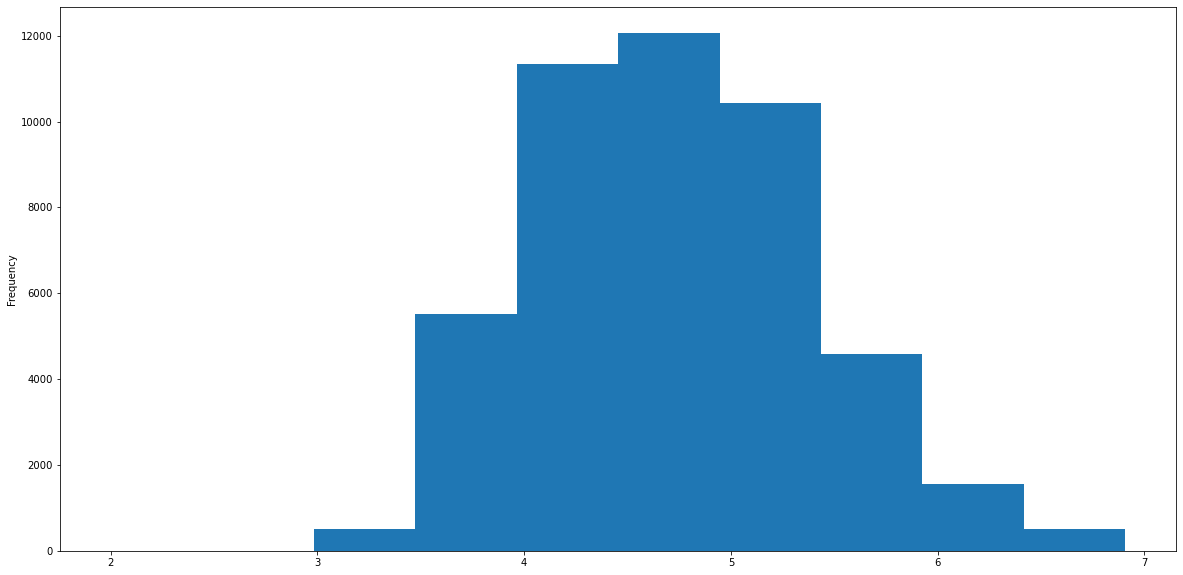

In [65]:
plt = np.log(listings_merge.price_year_avg).plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even after the cleaning process, we find that there is still a missing <b>price_fall_avg</b> value.  Averaging over nearest neighbors didn't catch everything!</p>

In [66]:
listings_merge.info()
listings_merge.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46512 entries, 1 to 48542
Columns: 171 entries, id to price_dec_avg
dtypes: float64(31), int64(136), object(4)
memory usage: 62.3+ MB


,id,neighbourhood,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.651200e+04,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,...,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000,46512.000000
mean,2.216350e+07,106.547601,40.728619,-73.950165,2.866486,1.135460,1.177675,1.524940,26.141426,94.076992,...,5.555782,5.553404,142.715216,142.392891,139.362421,143.946423,145.161644,141.441227,143.331285,145.188909
std,1.308181e+07,69.533597,0.055158,0.047766,1.819444,0.383943,0.726102,1.039615,49.781665,7.581204,...,8.135043,8.142107,116.780159,116.320226,114.124759,119.381595,120.919873,115.528441,120.437775,121.907443
min,2.595000e+03,0.000000,40.499790,-74.240840,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,...,1.000000,1.000000,7.397260,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,1.026870e+07,50.000000,40.689000,-73.982400,2.000000,1.000000,1.000000,1.000000,1.000000,93.000000,...,1.533333,1.411290,69.127397,70.000000,67.373626,69.032609,70.000000,70.000000,68.200000,70.000000
50%,2.182269e+07,95.000000,40.722400,-73.954520,2.000000,1.000000,1.000000,1.000000,6.000000,95.000000,...,2.400000,2.387097,108.527397,108.000000,105.000000,108.760870,110.000000,108.000000,106.000000,109.258065
75%,3.435617e+07,177.000000,40.762963,-73.932928,4.000000,1.000000,1.000000,2.000000,27.000000,99.000000,...,5.000000,5.000000,175.657534,175.000000,174.329670,178.000000,179.000000,175.000000,175.075000,178.750000
max,4.289272e+07,221.000000,40.910550,-73.711560,16.000000,5.000000,10.000000,12.000000,695.000000,100.000000,...,30.000000,30.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


In [67]:
for c in listings_merge.columns:
    print(c)

id
summary
neighbourhood
neighbourhood_group
latitude
longitude
room_type
accommodates
bathrooms
bedrooms
beds
amenities
number_of_reviews
review_scores_rating
reviews_per_month
entire_home_apt
24_hour_check_in
_toilet
accessible_height_bed
accessible_height_toilet
air_conditioning
air_purifier
baby_bath
baby_monitor
babysitter_recommendations
baking_sheet
barbecue_utensils
bathtub
bathtub_with_bath_chair
bbq_grill
beach_essentials
beachfront
bed_linens
bread_maker
breakfast
building_staff
buzzer_wireless_intercom
cable_tv
carbon_monoxide_detector
cats
changing_table
childrens_books_and_toys
childrens_dinnerware
cleaning_before_checkout
coffee_maker
cooking_basics
crib
disabled_parking_spot
dishes_and_silverware
dishwasher
dogs
doorman
dryer
electric_profiling_bed
elevator
essentials
ethernet_connection
ev_charger
extra_pillows_and_blankets
extra_space_around_bed
family_kid_friendly
fire_extinguisher
fireplace_guards
firm_mattress
first_aid_kit
fixed_grab_bars_for_shower
fixed_grab_bar

In [68]:
listings_merge_backup = listings_merge

In [69]:
listings_merge = listings_merge_backup

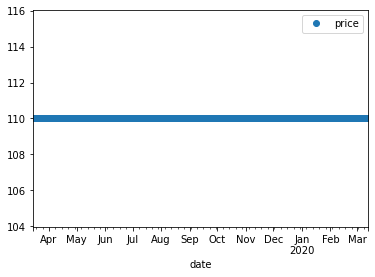

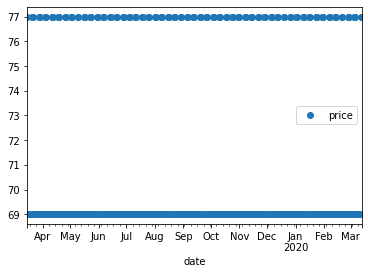

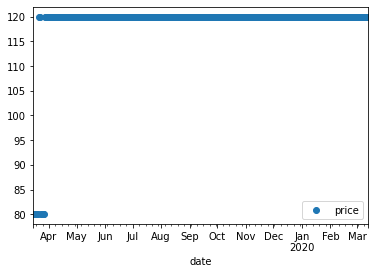

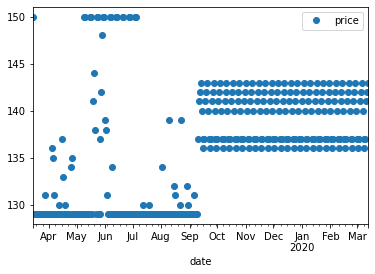

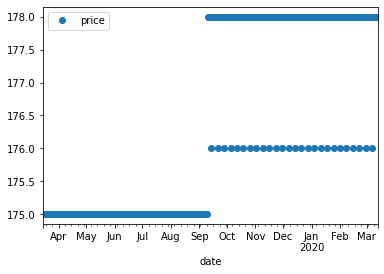

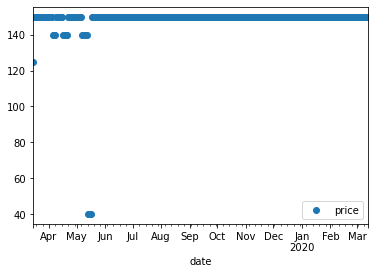

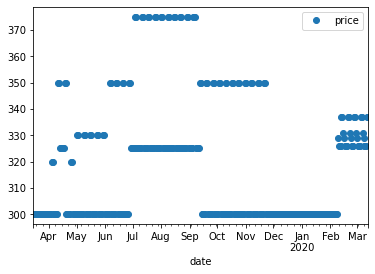

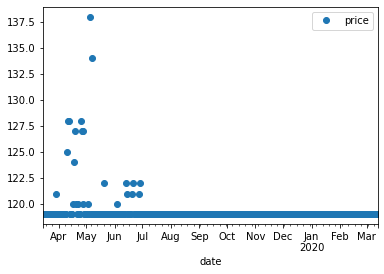

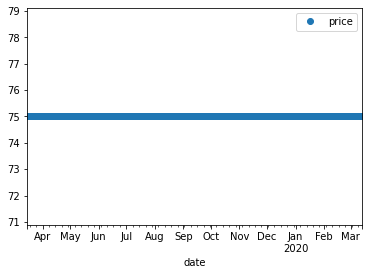

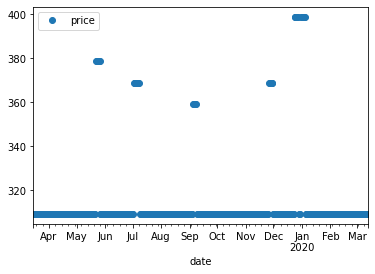

In [76]:
#Bronx 71812, 149777, Brooklyn 8490, 7726, Manhattan 2595, 5238, Queens 45910, 57166, Staten Island 225976, 639199
# listings_clean.loc[
#     (listings_clean.neighbourhood_group == 'Manhattan') &
#     (listings_clean.room_type == 'Entire home/apt')].head()
listings_ids = [71812, 149777, 8490, 7726, 2595, 5238, 45910, 57166, 225976, 639199]
for listing_id in listings_ids:
    calendar_clean.loc[calendar_clean.listing_id == listing_id].sort_values(by='date').plot(
        x='date', y='price', style='o'
    )

<br/>
<p>Let's do a final check for any correlated features.</p>

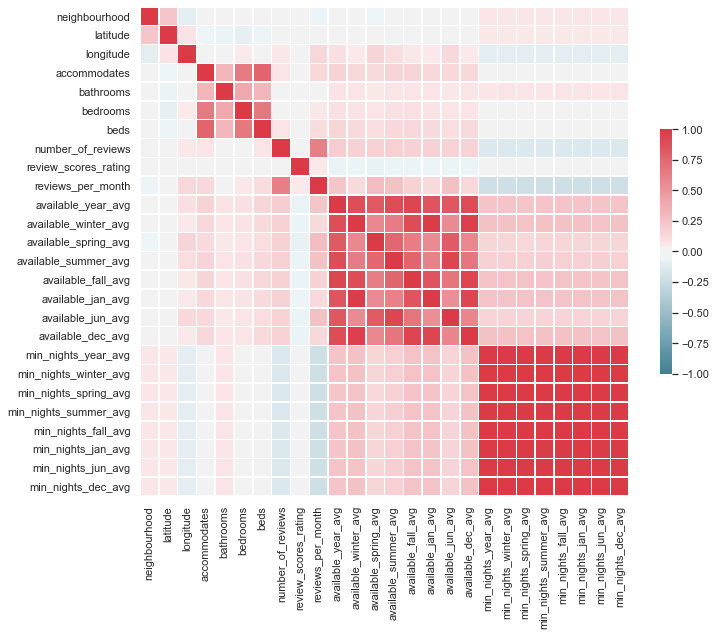

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

features = listings_merge[[
    'summary', 'neighbourhood', 'neighbourhood_group', 'latitude', 'longitude',
    'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'amenities', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg', 'available_fall_avg',
    'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg', 'min_nights_fall_avg',
    'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg'
]]

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(features.corr(), cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<p>We can see that <b>beds</b> and <b>accommodates</b> are heavily correlated with <b>bedrooms</b>.  We can drop those columns.  Other columns should be dropped as well to clean up any non-numerical data.</p>

In [78]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_base = listings_merge.amenities.str.join('|').str.get_dummies()
y = listings_merge.price_year_avg

X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)

clf = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=8,
    n_estimators=200,
    cv=5,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print('Feature set: all amenities')
print('Target label: price_year_avg')
print('Gradient boost R^2:', clf.score(X_test, y_test))
print('Gradient boost MAE:', mean_absolute_error(y_test, clf.predict(X_test)))

Feature set: all amenities
Target label: price_year_avg
Gradient boost R^2: 0.30688379746405814
Gradient boost MAE: 60.44829768848917


In [79]:
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

for k in [125, 100, 75, 50, 25]:
    X_base = listings_merge.amenities.str.join('|').str.get_dummies()
    y = listings_merge.price_year_avg

    selector = SelectKBest(f_classif, k=k)
    X_kbest = selector.fit_transform(X_base, y)

    X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=.25, random_state=42, shuffle=True)

    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=200,
        cv=5,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    print('Feature set:', k, 'amenities')
    print('Target label: price_year_avg')
    print('Gradient boost R^2:', clf.score(X_test, y_test))
    print('Gradient boost MAE:', mean_absolute_error(y_test, clf.predict(X_test)))

c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Feature set: 125 amenities
Target label: price_year_avg
Gradient boost R^2: 0.3082078948811855
Gradient boost MAE: 60.48501918543924


c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Feature set: 100 amenities
Target label: price_year_avg
Gradient boost R^2: 0.27297747492263547
Gradient boost MAE: 62.373794732068035


c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Feature set: 75 amenities
Target label: price_year_avg
Gradient boost R^2: 0.1604875858779875
Gradient boost MAE: 69.27791174141849


c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Feature set: 50 amenities
Target label: price_year_avg
Gradient boost R^2: 0.09852452922113042
Gradient boost MAE: 72.69948398105223


c:\users\bruce\miniconda3\envs\capstone\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Feature set: 25 amenities
Target label: price_year_avg
Gradient boost R^2: 0.023745905209968
Gradient boost MAE: 76.88828202534017


In [80]:
listings_merge = listings_merge.drop(['beds', 'accommodates'], axis=1)
listings_merge = listings_merge.drop(['id', 'room_type', 'neighbourhood_group'], axis=1)
listings_merge = listings_merge.drop(['reviews_per_month'], axis=1)
listings_merge = listings_merge.drop(['number_of_reviews'], axis=1)
listings_merge = listings_merge.drop(['summary', 'amenities'], axis=1)

# listings_merge = listings_merge.drop(['neighbourhood'], axis=1)
# listings_merge = listings_merge.drop(['review_scores_rating'], axis=1)
# listings_merge = listings_merge.drop(
#     ['available_year_avg', 'available_winter_avg', 'available_spring_avg',
#      'available_summer_avg', 'available_fall_avg', 'available_jan_avg',
#      'available_jun_avg','available_dec_avg'], axis=1)

In [81]:
X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
X_base.shape

(46512, 138)

<p>Perhaps we can add more features like monthly or holiday averages for availability, minimum nights required, and price, but that would make the table size explode!<p>

<h2>Modeling data with prices as target labels</h2>

<p>Now that we've cleaned up the data, let's look at several possible models of linear and non-linear type.  We will use average price of each listing over the year 2019, as well as seasonal average price as the target labels.  The easiest ones to get started with are Linear Regression and Random Forest.</p>

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)
    print('Target label:', combo[2])
    
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Linear regression R^2:", clf.score(X_test, y_test))
    print("Linear regression MAE:", mean_absolute_error(y_test, clf.predict(X_test)))

Target label: price_year_avg
Linear regression R^2: 0.4987559404681355
Linear regression MAE: 50.82093914799921
Target label: price_summer_avg
Linear regression R^2: 0.4989648834120881
Linear regression MAE: 51.95502955070159


In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)
    print('Target label:', combo[2])
    
    clf = RandomForestRegressor(n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Random forest R^2:", clf.score(X_test, y_test))
    print("Random forest MAE:", mean_absolute_error(y_test, clf.predict(X_test)))

Target label: price_year_avg
Random forest R^2: 0.6345184419214557
Random forest MAE: 38.681313033691644
Target label: price_summer_avg
Random forest R^2: 0.6311040523023018
Random forest MAE: 39.619217116480456


<p>We can see that Random Forest performs much better than Linear Regression in terms of R<sup>2</sup> score.</p>

<br/>
<p>Perhaps there will be an incremental improvement in R<sup>2</sup> by using Gradient Boosting (XGBoost in this case).</p>

In [84]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)

    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=200,
        cv=5,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('Gradient boost R^2:', clf.score(X_test, y_test))
    print('Gradient boost MAE:', mean_absolute_error(y_test, clf.predict(X_test)))

Target label: price_year_avg
Gradient boost R^2: 0.6700659131792424
Gradient boost MAE: 37.1816335695034
Target label: price_summer_avg
Gradient boost R^2: 0.6658160830028064
Gradient boost MAE: 38.021718832274075


<p>We get decent scores from a Gradient Boost model.</p>

<p>Will polynomial regression provide any benefit?  Let's find out.</p>

<p>It's odd that Polynomial Feature Transform + Linear Regresssion has such terrible scores.  Second degree Polynomial Feature Transform + Gradient Boosting performs close to Gradient Boosting alone.</p>

<p>Now apply deep learning with a neural network made up mainly of dense layers.</p>

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001)

def base_model():
    model = Sequential()
    model.add(Dense(150, input_dim=140, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])
    return model

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X_base.values)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.25, random_state=42, shuffle=True)

    
    clf = KerasRegressor(build_fn=base_model, epochs=100, batch_size=50, verbose=0, callbacks=[es], use_multiprocessing=1)
#     kfold = KFold(n_splits=5)
#     results = cross_val_score(clf, X_train, y_train, cv=kfold)
#     print(results)

    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('Neural network MAE:', mean_absolute_error(y_test, clf.predict(X_test)))

Epoch 00040: early stopping
Target label: price_year_avg
Neural network MAE: 47.651157442136366


<p>The best mean absolute error for average nightly price that can be achieved so far is around 42.  The mean of the average nightly price over the year is around 143.</p>